In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier

In [2]:
eng = pd.read_csv('/Users/Amin/Documents/GitHub/Springbord/Relax Challenge/takehome_user_engagement.csv')

In [3]:
eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
eng.nunique()

time_stamp    207220
user_id         8823
visited            1
dtype: int64

In [5]:
users = pd.read_csv('/Users/Amin/Documents/GitHub/Springbord/Relax Challenge/takehome_users.csv',encoding='latin-1')

In [6]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


First we need to see which users are adopted. 

In [7]:
eng.time_stamp = pd.to_datetime(eng.time_stamp)
eng = eng.set_index('time_stamp', drop= True)

In [8]:
eng.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


### Labeling The adopted users

In [9]:
def label(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = eng.loc[eng['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted


In [10]:
users['adopted_user'] = users['object_id'].apply(label)

In [11]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [12]:
sum(users['adopted_user'])

1656

In [13]:
users.object_id.count()

12000

There are only 1656 adopted user amoung 12000 users.

In [14]:
round((sum(users['adopted_user'])/users.object_id.count()*100),2)

13.8

13.8 percent of users are being adopted to the product.

### Features Engineering:

In [15]:
users.invited_by_user_id.fillna(0,inplace=True)

### num_referrals:
calculate how many other users referes by the target users. This way we can find out the "influencer" users whom refers the product to so many other users. 

In [16]:
users.invited_by_user_id.value_counts()

0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
           ... 
2071.0        1
1390.0        1
5445.0        1
8526.0        1
5450.0        1
Name: invited_by_user_id, Length: 2565, dtype: int64

In [17]:
user_invited = pd.DataFrame(users.invited_by_user_id.value_counts()).reset_index()
user_invited.columns=['object_id', 'num_referals']
users = users.merge(user_invited, how='left', on='object_id')
users['num_referals'] = users['num_referals'].fillna(0)

In [18]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_referals
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,0.0


### num_referal_class:

This just being a categoriez version of num_refereal. It shows how many users this user referes. Large,medium,small or no referal.

In [19]:
def getReferralSize(x):
    size='M' #default M (2,3,4)
    if x>=5: # 5~13: Large
        size='L'
    elif x==1: # 1: Small
        size='S'
    elif x==0:
        size='Not_invited'
    return size

users['num_referal_class']=users.num_referals.apply(getReferralSize)


In [20]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_referals,num_referal_class
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,0.0,Not_invited
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,0.0,Not_invited
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1.0,S
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,0.0,Not_invited
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,0.0,Not_invited


### email_domain:

Extract the domain of the email each user used to create a account.

In [21]:
users['email_domain'] = [x.split('@')[1] for x in users.email]

In [22]:
top5_Domain = users.email_domain.value_counts()[0:6]

In [23]:
users['email_domain'] = [x if x in top5_Domain else "others" for x in users.email_domain]

In [24]:
users.email_domain.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
others            1186
gustr.com         1179
hotmail.com       1165
Name: email_domain, dtype: int64

### org_size:

If we count the organization id and how many users loging from each organization we can evaluate the size of the organization based on that.

In [25]:
org_count = pd.DataFrame(users.org_id.value_counts().reset_index())
org_count.columns=['org_id', 'num_org']

In [26]:
def getOrgSize(x):
    size='Tiny' #default M (2,3,4)
    if x>=200: # over 200: Extreme
        size='Super'
    elif x>=100: # over 100: Many
        size='Big'
    elif x>=50: 
        size="Moderate"
    elif x>=10:
        size="Small"
    return size

org_count['org_size_inf']=org_count.num_org.apply(getOrgSize)

In [27]:
users = users.merge(org_count, how='left', on='org_id')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_referals,num_referal_class,email_domain,num_org,org_size_inf
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,0.0,Not_invited,yahoo.com,75,Moderate
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,0.0,Not_invited,gustr.com,233,Super
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1.0,S,gustr.com,32,Small
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,0.0,Not_invited,yahoo.com,233,Super
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,0.0,Not_invited,yahoo.com,16,Small


### length_usage:

This is the the users use the system to check the product. It calculated by subtracting the last time the user login from the first time the user create the account

In [28]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users.last_session_creation_time.fillna(users['creation_time'],inplace=True)

In [29]:
users['creation_time'] = pd.to_datetime(users.creation_time)

In [30]:
users['length_usage'] = users.last_session_creation_time - users.creation_time
users['length_usage'] = users['length_usage'].dt.components.days

In [31]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,num_referals,num_referal_class,email_domain,num_org,org_size_inf,length_usage
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,0.0,Not_invited,yahoo.com,75,Moderate,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,0.0,Not_invited,gustr.com,233,Super,136
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,1.0,S,gustr.com,32,Small,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,0.0,Not_invited,yahoo.com,233,Super,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,0.0,Not_invited,yahoo.com,16,Small,5


### creation_firstlogin:

This is the diffrence between the day that user create the account and the first time the user login.

In [32]:
eng = eng.reset_index()

In [33]:
df_firstLogin = eng.groupby('user_id', as_index=False).agg({'time_stamp' : np.min})
df_firstLogin.columns=['object_id', 'firstLogin_time']
df_firstLogin.head()

,object_id,firstLogin_time
0,1,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52
3,4,2013-05-22 08:09:28
4,5,2013-01-22 10:14:20


In [34]:
users = users.merge(df_firstLogin, how='left', on='object_id')

In [35]:
users.firstLogin_time.fillna(users['creation_time'],inplace=True)

In [36]:
users['creation_firstlogin'] = (users['firstLogin_time'] - users['creation_time']).dt.days

### Exploratory Data Analysis:

In [37]:
users = users.drop(columns=['object_id','creation_time','name','email','last_session_creation_time','org_id','invited_by_user_id','firstLogin_time'])

In [38]:
users.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,num_referals,num_referal_class,email_domain,num_org,org_size_inf,length_usage,creation_firstlogin
0,GUEST_INVITE,1,0,0,0.0,Not_invited,yahoo.com,75,Moderate,0,0
1,ORG_INVITE,0,0,1,0.0,Not_invited,gustr.com,233,Super,136,0
2,ORG_INVITE,0,0,0,1.0,S,gustr.com,32,Small,0,0
3,GUEST_INVITE,0,0,0,0.0,Not_invited,yahoo.com,233,Super,1,1
4,GUEST_INVITE,0,0,0,0.0,Not_invited,yahoo.com,16,Small,5,5


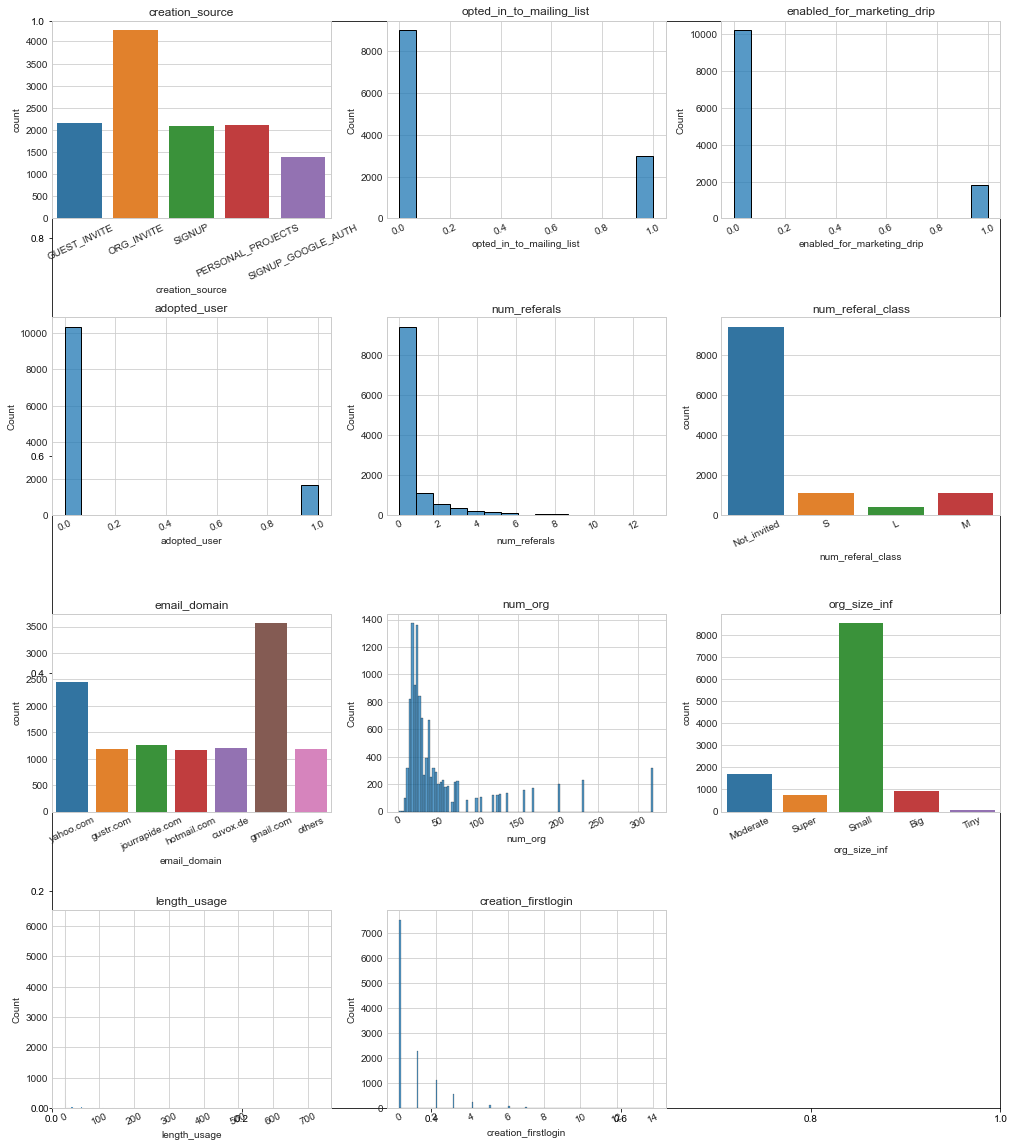

In [39]:
fig,ax = plt.subplots(figsize=(17,20))
plt.style.use('seaborn-whitegrid')
fig.subplots_adjust(wspace=0.2, hspace=0.5)
for i, col in enumerate(users.columns):
    ax = fig.add_subplot(4,3,i+1)
    ax.set_title(col)
    if users.dtypes[col] == object:
        g = sns.countplot(x=col, data=users)
        plt.xticks(rotation=25)

    else:
        g = sns.histplot(users[col])
        plt.xticks(rotation=25)

    

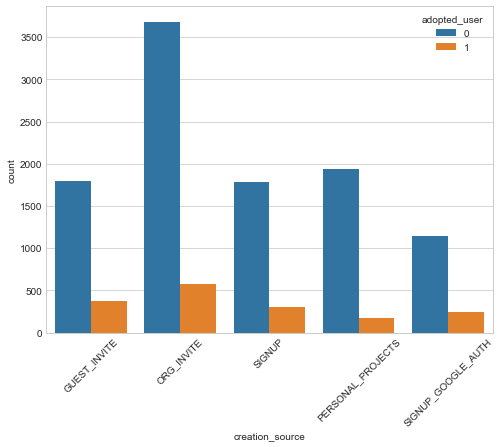

In [40]:
fig,ax = plt.subplots(figsize=(8,6))
_ = sns.countplot(x='creation_source',hue='adopted_user',data=users)
_ = plt.xticks(rotation=45)

Most of the account created by the original invite form the web site and those users are more adopted in compare to other sources.

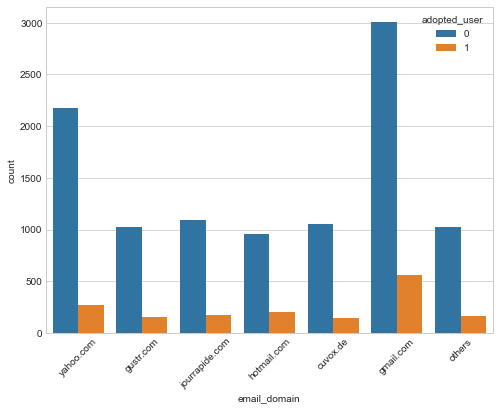

In [41]:
fig,ax = plt.subplots(figsize=(8,6))
_ = sns.countplot(x='email_domain',hue='adopted_user',data=users)
_ = plt.xticks(rotation=45)

Most of the account created by gmail and those users are more adopted in compare to other sources. There are also lots of yahoo email but those tends to adopt in a way less number.

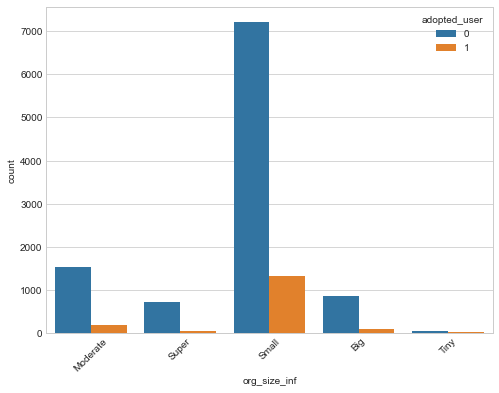

In [42]:
fig,ax = plt.subplots(figsize=(8,6))
_ = sns.countplot(x='org_size_inf',hue='adopted_user',data=users)
_ = plt.xticks(rotation=45)

most of the users are from a small company and they are the most adopted users as well.

### Feature selection:

In [43]:
users.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,num_referals,num_referal_class,email_domain,num_org,org_size_inf,length_usage,creation_firstlogin
0,GUEST_INVITE,1,0,0,0.0,Not_invited,yahoo.com,75,Moderate,0,0
1,ORG_INVITE,0,0,1,0.0,Not_invited,gustr.com,233,Super,136,0
2,ORG_INVITE,0,0,0,1.0,S,gustr.com,32,Small,0,0
3,GUEST_INVITE,0,0,0,0.0,Not_invited,yahoo.com,233,Super,1,1
4,GUEST_INVITE,0,0,0,0.0,Not_invited,yahoo.com,16,Small,5,5


In [44]:
# Hot encoding the categorical columns
users = pd.get_dummies(users,columns=['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip',
                              'num_referal_class','email_domain','org_size_inf'],prefix_sep='_', drop_first=True)

In [45]:
users.head()

,adopted_user,num_referals,num_org,length_usage,creation_firstlogin,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,...,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_others,email_domain_yahoo.com,org_size_inf_Moderate,org_size_inf_Small,org_size_inf_Super,org_size_inf_Tiny
0,0,0.0,75,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,1,0.0,233,136,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,1.0,32,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0.0,233,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0.0,16,5,5,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [46]:
X = users.drop(columns=['adopted_user'])
y = users.adopted_user

In [47]:
rfc = RandomForestClassifier()
rfc.fit(X,y)

RandomForestClassifier()

In [48]:
rfc.feature_importances_

array([6.36083550e-03, 5.49879848e-02, 8.50565620e-01, 2.29161826e-02,
       6.49196123e-03, 5.09813791e-03, 4.95675524e-03, 2.85602346e-03,
       6.68858341e-03, 5.37310764e-03, 1.68685423e-03, 2.27991752e-03,
       1.99895421e-03, 4.52143177e-03, 3.30782328e-03, 3.61055982e-03,
       2.46993206e-03, 3.09943424e-03, 3.58920604e-03, 1.68296911e-03,
       3.58002460e-03, 1.37359493e-03, 5.04106358e-04])

In [49]:
rfc.feature_names_in_

array(['num_referals', 'num_org', 'length_usage', 'creation_firstlogin',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'opted_in_to_mailing_list_1', 'enabled_for_marketing_drip_1',
       'num_referal_class_M', 'num_referal_class_Not_invited',
       'num_referal_class_S', 'email_domain_gmail.com',
       'email_domain_gustr.com', 'email_domain_hotmail.com',
       'email_domain_jourrapide.com', 'email_domain_others',
       'email_domain_yahoo.com', 'org_size_inf_Moderate',
       'org_size_inf_Small', 'org_size_inf_Super', 'org_size_inf_Tiny'],
      dtype=object)

In [50]:
importance = pd.DataFrame(rfc.feature_importances_,index=X.columns,columns=["Importance"])
importance = importance.sort_values(by="Importance",ascending=True)

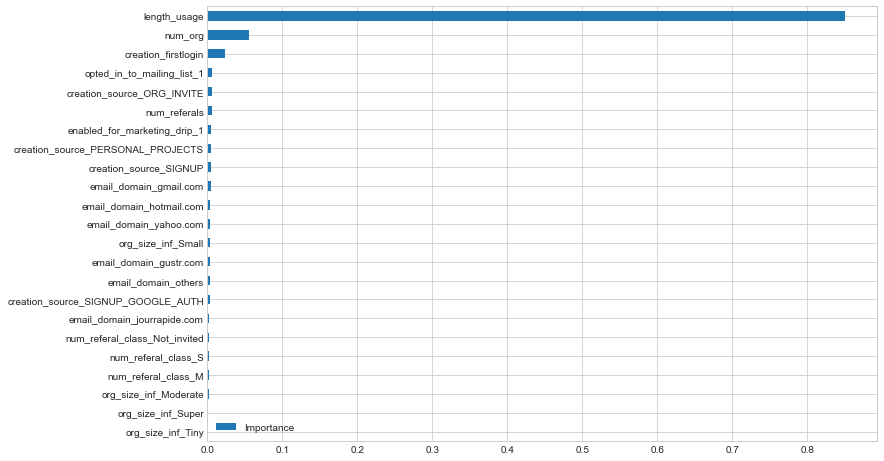

In [51]:
_ = importance.plot(kind='barh',figsize=(12,8))

### Conclusion:

1) Using the RandomForest Classifer, we fit the data to th emodel and exctract the features importance from it. It is clear that the __lenght_usage__ is the most important feature by a large margin. __This is the time diffrence between the first and last login of the user.__

2) The following features are: 
   * num_org:  how many peple from same organization create a account.
   * creation_firstlogin: the time diffrence between the creation of the account and the first login to the account.
   * opted_in_to_mailing_list_1: those are the users that opt in the mailing list.
   * num_referals : How many others referes by the user.

